In [9]:
import numpy as np
import zipfile
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [2]:
zip_path = "/content/archive.zip"
extract_path = "brain_tumor_data"


os.makedirs(extract_path, exist_ok=True)


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extracted to: {extract_path}")
print("Folders inside:", os.listdir(extract_path))


Extracted to: brain_tumor_data
Folders inside: ['metadata.csv', 'metadata_rgb_only.csv', 'Brain Tumor Data Set']


In [3]:
base_dir = "/content/brain_tumor_data/Brain Tumor Data Set/Brain Tumor Data Set"
print(os.listdir(base_dir))

['Healthy', 'Brain Tumor']


In [4]:
# Rename folders to 'no' and 'yes'
os.rename(os.path.join(base_dir, 'Healthy'), os.path.join(base_dir, 'no'))
os.rename(os.path.join(base_dir, 'Brain Tumor'), os.path.join(base_dir, 'yes'))

print("Renamed folders:", os.listdir(base_dir))


Renamed folders: ['no', 'yes']


In [5]:
import shutil
from sklearn.model_selection import train_test_split

# New class names
classes = ['yes', 'no']

# Folder to store the split data
split_base = "/content/brain_tumor_split"

# Create split folders
for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(split_base, split, cls), exist_ok=True)

# Split and copy images
for cls in classes:
    img_dir = os.path.join(base_dir, cls)
    images = os.listdir(img_dir)

    # Split: 10% test, 20% val from remaining
    train_val, test = train_test_split(images, test_size=0.1, random_state=42)
    train, val = train_test_split(train_val, test_size=0.2, random_state=42)

    # Copy to respective folders
    for fname in train:
        shutil.copy(os.path.join(img_dir, fname), os.path.join(split_base, 'train', cls))
    for fname in val:
        shutil.copy(os.path.join(img_dir, fname), os.path.join(split_base, 'val', cls))
    for fname in test:
        shutil.copy(os.path.join(img_dir, fname), os.path.join(split_base, 'test', cls))

print(" Dataset successfully split!")


 Dataset successfully split!


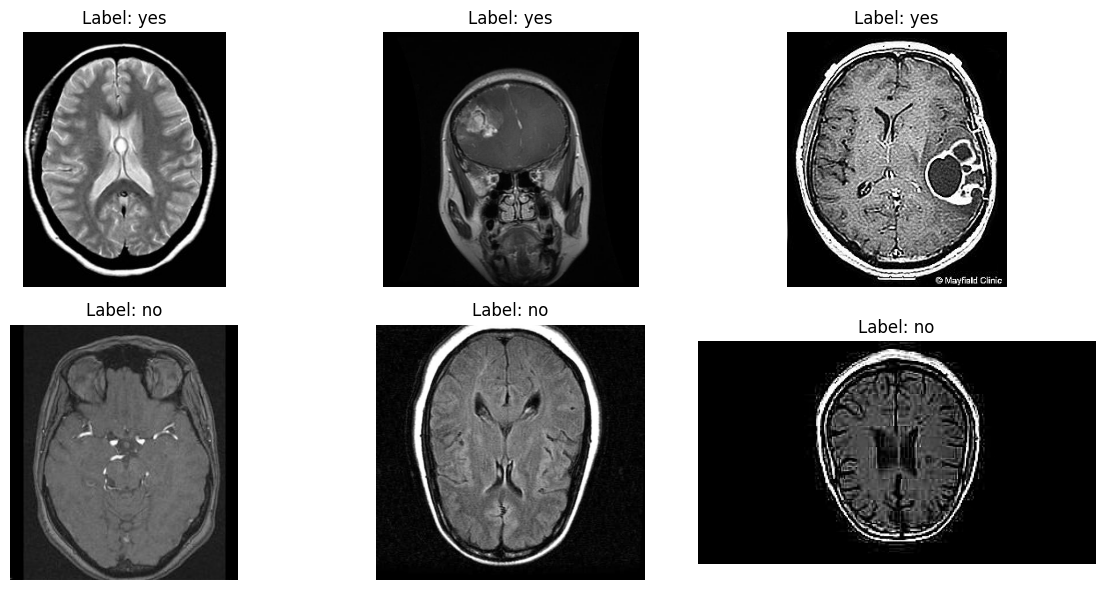

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

# Path to training data
train_dir = "/content/brain_tumor_split/train"
classes = ['yes', 'no']

# Prepare 6 random image paths
sample_images = []

for cls in classes:
    class_dir = os.path.join(train_dir, cls)
    images = random.sample(os.listdir(class_dir), 3)  # 3 from each class
    sample_images.extend([(os.path.join(class_dir, img), cls) for img in images])

# Plot the images
plt.figure(figsize=(12, 6))
for i, (img_path, label) in enumerate(sample_images):
    img = mpimg.imread(img_path)
    plt.subplot(2, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [7]:
for split in ['train', 'val', 'test']:
    for cls in classes:
        count = len(os.listdir(os.path.join(split_base, split, cls)))
        print(f"{split}/{cls}: {count} images")


train/yes: 1808 images
train/no: 1502 images
val/yes: 453 images
val/no: 376 images
test/yes: 252 images
test/no: 209 images


In [11]:
# Image settings
img_size = (256, 256)
batch_size = 32

# Data Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)


In [12]:
# Validation & test: only rescale
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Set directory paths
train_dir = "/content/brain_tumor_split/train"
val_dir = "/content/brain_tumor_split/val"
test_dir = "/content/brain_tumor_split/test"

In [13]:

# Create generators
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 3310 images belonging to 2 classes.
Found 829 images belonging to 2 classes.
Found 461 images belonging to 2 classes.


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,105 (56.61 MB)

 Trainable params: 14,839,105 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


early_stop = EarlyStopping(patience=3, restore_best_weights=True)



In [16]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.5721 - loss: 0.6741

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


104/104 ━━━━━━━━━━━━━━━━━━━━ 67s 561ms/step - accuracy: 0.5724 - loss: 0.6739 - val_accuracy: 0.7274 - val_loss: 0.5637
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 53s 507ms/step - accuracy: 0.7164 - loss: 0.5869 - val_accuracy: 0.7527 - val_loss: 0.5331
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 53s 512ms/step - accuracy: 0.7489 - loss: 0.5352 - val_accuracy: 0.7491 - val_loss: 0.5122
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 82s 511ms/step - accuracy: 0.7533 - loss: 0.5183 - val_accuracy: 0.7660 - val_loss: 0.4839
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 54s 515ms/step - accuracy: 0.7867 - loss: 0.4710 - val_accuracy: 0.7708 - val_loss: 0.4743
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 53s 506ms/step - accuracy: 0.7991 - loss: 0.4559 - val_accuracy: 0.7817 - val_loss: 0.4712
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 52s 503ms/step - accuracy: 0.7901 - loss: 0.4540 - val_accuracy: 0.7877 - val_loss: 0.4620
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 53s 510ms/step - accuracy: 0.8131 - loss: 0.4297 - val

In [17]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.8327 - loss: 0.3057
Test Accuracy: 0.8633, Test Loss: 0.2811


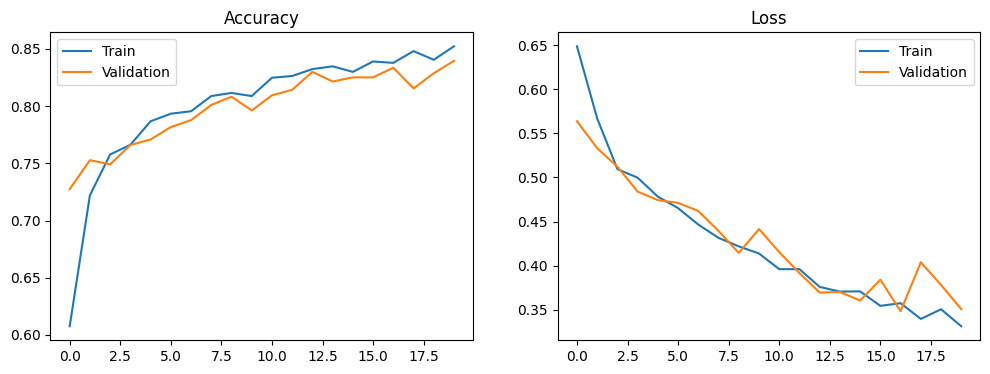

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.show()


In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get true labels and predictions
y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_labels = (y_pred > 0.5).astype(int).flatten()

# Metrics
print(confusion_matrix(y_true, y_pred_labels))
print(classification_report(y_true, y_pred_labels, target_names=['no', 'yes']))


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step
[[168  41]
 [ 22 230]]
              precision    recall  f1-score   support

          no       0.88      0.80      0.84       209
         yes       0.85      0.91      0.88       252

    accuracy                           0.86       461
   macro avg       0.87      0.86      0.86       461
weighted avg       0.86      0.86      0.86       461



In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_brain_tumor(img_path, model):
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)[0][0]
    return "Tumor" if pred > 0.5 else "Healthy"


In [ ]:
img_path ="/content/big_5b252c1a32b7d.jpg"

predict_brain_tumor(img_path, model)
